In [1]:
%reload_ext tensorboard
%tensorboard --logdir ./darts_logs --host localhost --port 8099

In [2]:
from helper_funcs.data import cleaned_market
from helper_funcs.preprocessing import timeseries_init, get_covariates
from helper_funcs.prediction import historical_predictions, display_prediction_part
from helper_funcs.error import error_print
from helper_funcs.inverse import inverse_func

from models import nlinear, tft, dlinear

from darts import TimeSeries
# from darts.timeseries import concatenate
from darts.models import NaiveSeasonal
from darts.utils.model_selection import train_test_split
from darts.dataprocessing.transformers import StaticCovariatesTransformer, Scaler

from pytorch_lightning.callbacks import ModelCheckpoint, RichProgressBar

from sklearn.preprocessing import StandardScaler

import torchmetrics
import torch

import pandas as pd

In [3]:
RANDOM = 101
INPUT_CHUNK = 25
OUTPUT_CHUNK = 5
RETRAIN=True
LAST=False
RESET=False

checkpoint = ModelCheckpoint(monitor="val_loss")
progress_bar = RichProgressBar()

In [4]:
callbacks=[progress_bar]

In [5]:
# timeseries = timeseries_init(
#     time_col='Date',
#     static_cols=[],
#     value_cols=[
#         'Adj Close',
#         'Close',
#         'High',
#         'Low',
#         'Open',
#         'Volume'
#     ],
#     freq='B', # business days
#     fill_missing=True,
#     group_col='Ticker',
#     type='MULTI'
# )

timeseries = timeseries_init(
    time_col='Date',
    static_cols=[],
    value_cols=[
        'Adj Close', 'Close', 'High', 'Low',
        'Open', 'Volume', 'sentiment'],
    freq='B', # business days
    fill_missing=True,
    group_col='Ticker',
    type='Sentiment'
)

timeseries = StaticCovariatesTransformer().fit_transform(timeseries)

In [6]:
train, val = train_test_split(
    timeseries,
    axis=1,
    test_size=0.2,
    input_size=INPUT_CHUNK,
    horizon=OUTPUT_CHUNK,
    vertical_split_type='model-aware'
)

In [7]:
len(train[0]), len(val[0])

(1040, 288)

In [8]:
target_train, past_train, future_train,target_val, past_val, future_val = get_covariates(
        type='MULTI',
        data={"train": train, "val": val},
        target_col=['Close'],
        past_cov=['High', 'Low', 'Open', 'Volume'],
        future_cov=['holidays'])

In [9]:
target_train_sent, past_train_sent, _, target_val_sent, past_val_sent, _ = get_covariates(
        type='MULTI',
        data={"train": train, "val": val},
        target_col=['Close'],
        past_cov=['High', 'Low', 'Open', 'Volume', 'sentiment'],
        future_cov=['holidays'])

# Scaling

In [10]:
scaler_target = Scaler(StandardScaler())
scaler_past = Scaler(StandardScaler())

scaler_target_sent = Scaler(StandardScaler())
scaler_past_sent = Scaler(StandardScaler())

# without sentiment
target_train_scaled = scaler_target.fit_transform(target_train)
target_val_scaled = scaler_target.transform(target_val)

past_train_scaled = scaler_past.fit_transform(past_train)
past_val_scaled = scaler_past.transform(past_val)

# with sentiment
target_train_sent_scaled = scaler_target_sent.fit_transform(target_train_sent)
target_val_sent_scaled = scaler_target_sent.transform(target_val_sent)

past_train_sent_scaled = scaler_past_sent.fit_transform(past_train_sent)
past_val_sent_scaled = scaler_past_sent.transform(past_val_sent)

# Models

In [11]:
model_baseline = NaiveSeasonal(K=5)
model_baseline.fit(target_train[0])

In [12]:
model_nlinear_default = nlinear.nlinear_default(INPUT_CHUNK, OUTPUT_CHUNK, RANDOM, \
    callbacks, target_train, target_val)

In [13]:
model_nlinear_minmax = nlinear.nlinear_minmax(INPUT_CHUNK, OUTPUT_CHUNK, RANDOM, \
    callbacks, target_train_scaled, target_val_scaled)

In [14]:
model_nlinear_minmax_cov = nlinear.nlinear_minmax_cov(INPUT_CHUNK, OUTPUT_CHUNK, RANDOM, \
    callbacks, target_train_scaled, target_val_scaled, past_train_scaled, past_val_scaled, \
        future_train, future_val)

In [15]:
model_nlinear_minmax_sentiment = nlinear.nlinear_minmax_sentiment(INPUT_CHUNK, OUTPUT_CHUNK, RANDOM, \
    callbacks, target_train_sent_scaled, target_val_sent_scaled, past_train_sent_scaled, past_val_sent_scaled, \
        future_train, future_val)

In [16]:
model_nlinear_minmax_sentiment_opt = nlinear.nlinear_minmax_sentiment_opt(INPUT_CHUNK, OUTPUT_CHUNK, RANDOM, \
    callbacks, target_train_sent_scaled, target_val_sent_scaled, past_train_sent_scaled, past_val_sent_scaled, \
        future_train, future_val)

In [17]:
model_tft_sentiment_opt = tft.tft_sentiment_opt(INPUT_CHUNK, OUTPUT_CHUNK, RANDOM, \
    callbacks, target_train_sent_scaled, target_val_sent_scaled, past_train_sent_scaled, past_val_sent_scaled, \
        future_train, future_val)

In [18]:
model_dlinear_sentiment = dlinear.dlinear_sentiment(INPUT_CHUNK, OUTPUT_CHUNK, RANDOM, \
    callbacks, target_train_sent_scaled, target_val_sent_scaled, past_train_sent_scaled, past_val_sent_scaled, \
        future_train, future_val)

# Forecasts

In [19]:
hist_baseline = historical_predictions(
    model_baseline, target_val, INPUT_CHUNK, OUTPUT_CHUNK, RETRAIN, LAST
)

hist_def = historical_predictions(
    model_nlinear_default, target_val, INPUT_CHUNK, OUTPUT_CHUNK, RETRAIN, LAST)

hist_mm = historical_predictions(
    model_nlinear_minmax, target_val_scaled, INPUT_CHUNK, OUTPUT_CHUNK, RETRAIN, LAST)

hist_mm_cov = historical_predictions(
    model_nlinear_minmax_cov, target_val_scaled, INPUT_CHUNK, OUTPUT_CHUNK, RETRAIN, LAST, \
        covariates=True, past=past_val_scaled, future=future_val
    )

hist_sentiment = historical_predictions(
    model_nlinear_minmax_sentiment, target_val_sent_scaled, INPUT_CHUNK, OUTPUT_CHUNK, RETRAIN, LAST, \
        covariates=True, past=past_val_sent_scaled, future=future_val
    )

hist_sentiment_opt = historical_predictions(
    model_nlinear_minmax_sentiment_opt, target_val_sent_scaled, INPUT_CHUNK, OUTPUT_CHUNK, RETRAIN, LAST, \
        covariates=True, past=past_val_sent_scaled, future=future_val
    )

hist_tft_sentiment_opt = historical_predictions(
    model_tft_sentiment_opt, target_val_sent_scaled, INPUT_CHUNK, OUTPUT_CHUNK, RETRAIN, LAST, \
        covariates=True, past=past_val_sent_scaled, future=future_val
    )

hist_dlinear_sentiment = historical_predictions(
    model_dlinear_sentiment, target_val_sent_scaled, INPUT_CHUNK, OUTPUT_CHUNK, RETRAIN, LAST, \
        covariates=True, past=past_val_sent_scaled, future=future_val
    )

In [20]:
def diplay_prediction(hist, target, inverse=False, scaler=None):
    if inverse:
        hist, target = inverse_func(scaler, hist, target)

    hist.plot(label='predict')
    target[0][30:].plot(label='true')

    error_print(target[0], hist)

    return hist

### Baseeline

MAPE error is 2.59564 % 
MAE error is 1.32740 % 
R2 error is 0.95985 % 
RMSE error is 1.67721 % 
SMAPE error is 2.61830 %


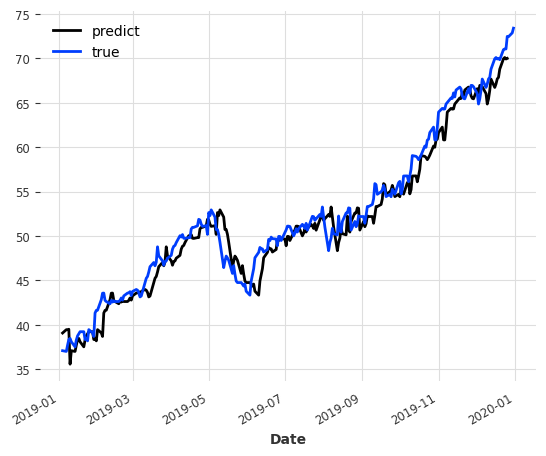

In [21]:
hist_baselinee = diplay_prediction(hist_baseline, target_val, inverse=False)

### Normalization

MAPE error is 3.07662 % 
MAE error is 1.54197 % 
R2 error is 0.94046 % 
RMSE error is 2.04261 % 
SMAPE error is 3.08655 %


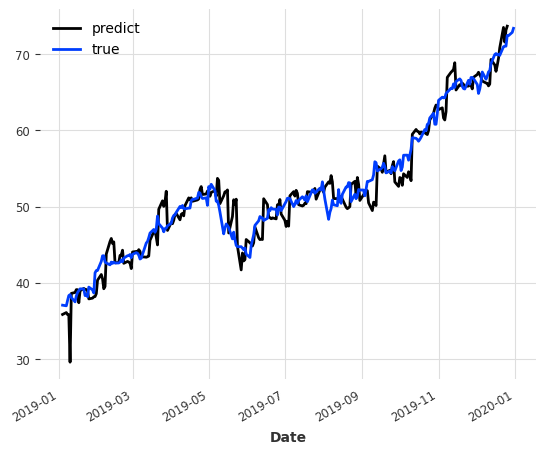

In [22]:
hist_def = diplay_prediction(hist_def, target_val, inverse=False)

### MinMax

MAPE error is 2.95472 % 
MAE error is 1.47563 % 
R2 error is 0.94654 % 
RMSE error is 1.93549 % 
SMAPE error is 2.94672 %


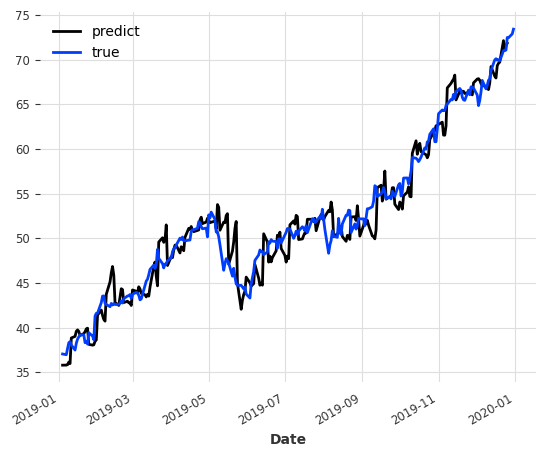

In [23]:
hist_mm = diplay_prediction(hist_mm, target_val_scaled, inverse=True, scaler=scaler_target)

### Covariates

MAPE error is 2.60234 % 
MAE error is 1.33733 % 
R2 error is 0.95821 % 
RMSE error is 1.71116 % 
SMAPE error is 2.60748 %


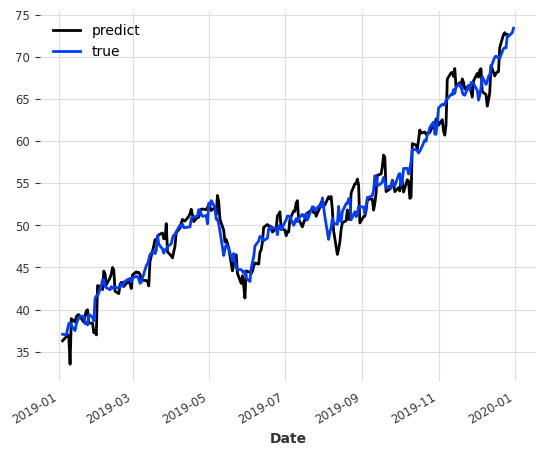

In [24]:
hist_mm_cov = diplay_prediction(hist_mm_cov, target_val_scaled, inverse=True, scaler=scaler_target)

### Sentiment

MAPE error is 2.40456 % 
MAE error is 1.23511 % 
R2 error is 0.96235 % 
RMSE error is 1.62433 % 
SMAPE error is 2.40856 %


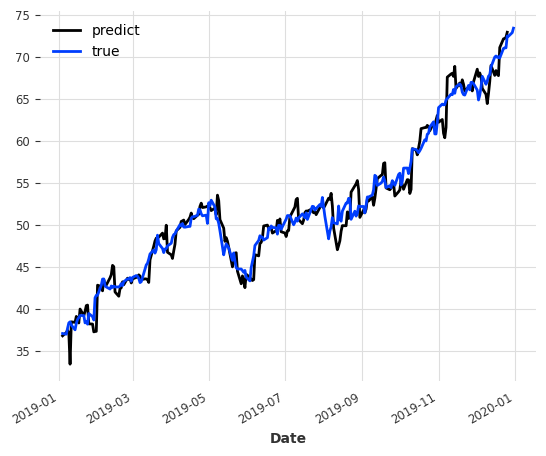

In [25]:
hist_sentiment = diplay_prediction(hist_sentiment, target_val_sent_scaled, inverse=True, scaler=scaler_target_sent)

### Sentiment opt

MAPE error is 2.44249 % 
MAE error is 1.25400 % 
R2 error is 0.96255 % 
RMSE error is 1.61996 % 
SMAPE error is 2.44694 %


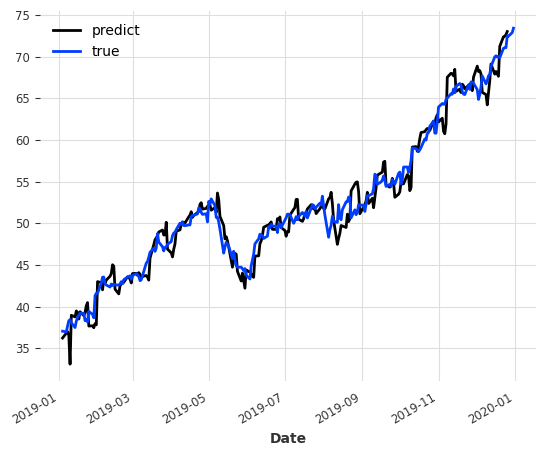

In [26]:
hist_sentiment_opt = diplay_prediction(hist_sentiment_opt, target_val_sent_scaled, inverse=True, scaler=scaler_target_sent)

### TFT opt

MAPE error is 2.43012 % 
MAE error is 1.25297 % 
R2 error is 0.96370 % 
RMSE error is 1.59476 % 
SMAPE error is 2.44768 %


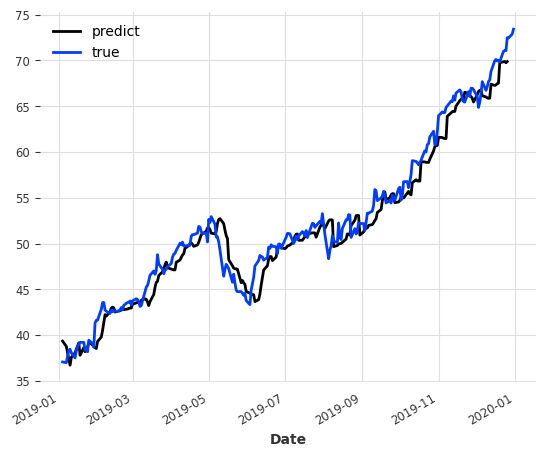

In [27]:
hist_tft_sentiment_opt = diplay_prediction(hist_tft_sentiment_opt, target_val_sent_scaled, inverse=True, scaler=scaler_target_sent)

### DLinear

MAPE error is 2.58470 % 
MAE error is 1.31122 % 
R2 error is 0.96152 % 
RMSE error is 1.64200 % 
SMAPE error is 2.58852 %


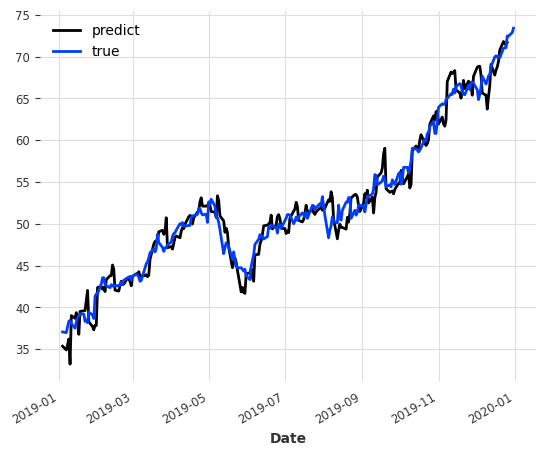

In [28]:
hist_dlinear_sentiment = diplay_prediction(hist_dlinear_sentiment, target_val_sent_scaled, inverse=True, scaler=scaler_target_sent)

# DELIMEIRET

baseline errors
MAPE error is 3.56420 % 
MAE error is 1.68367 % 
R2 error is 0.51251 % 
RMSE error is 2.07230 % 
SMAPE error is 3.48591 %
----------------------------------------------------------
sentiment errors
MAPE error is 2.53141 % 
MAE error is 1.19896 % 
R2 error is 0.74911 % 
RMSE error is 1.48666 % 
SMAPE error is 2.52594 %
----------------------------------------------------------
tft errors
MAPE error is 3.57163 % 
MAE error is 1.68652 % 
R2 error is 0.50594 % 
RMSE error is 2.08621 % 
SMAPE error is 3.49230 %
----------------------------------------------------------
dlinear errors
MAPE error is 3.03874 % 
MAE error is 1.43285 % 
R2 error is 0.63918 % 
RMSE error is 1.78285 % 
SMAPE error is 3.04561 %
----------------------------------------------------------


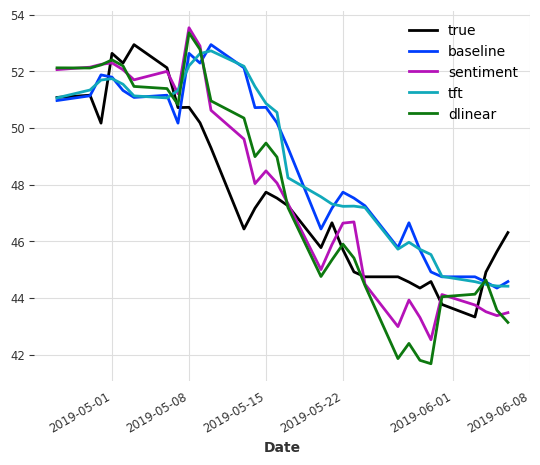

In [29]:
display_prediction_part(target_val, 110, 140, \
    {
        'baseline': hist_baseline,
        # 'default': hist_def,
        # 'minmax': hist_mm,
        # 'covariate': hist_mm_cov,
        'sentiment': hist_sentiment,
        # 'sentiment_opt': hist_sentiment_opt,
        'tft': hist_tft_sentiment_opt,
        'dlinear': hist_dlinear_sentiment
    })

baseline errors
MAPE error is 4.37231 % 
MAE error is 2.04083 % 
R2 error is -0.71387 % 
RMSE error is 2.40418 % 
SMAPE error is 4.45009 %
----------------------------------------------------------
sentiment errors
MAPE error is 2.55984 % 
MAE error is 1.17415 % 
R2 error is 0.40479 % 
RMSE error is 1.41682 % 
SMAPE error is 2.60755 %
----------------------------------------------------------
tft errors
MAPE error is 4.37330 % 
MAE error is 2.04317 % 
R2 error is -0.68477 % 
RMSE error is 2.38368 % 
SMAPE error is 4.45629 %
----------------------------------------------------------
dlinear errors
MAPE error is 3.26785 % 
MAE error is 1.49057 % 
R2 error is 0.01894 % 
RMSE error is 1.81897 % 
SMAPE error is 3.34774 %
----------------------------------------------------------


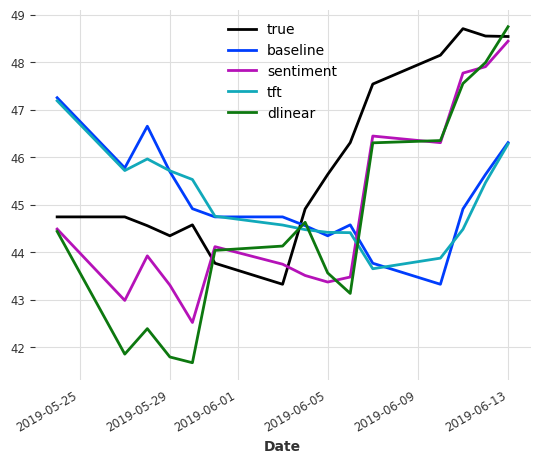

In [30]:
display_prediction_part(target_val, 130, 145, \
    {
        'baseline': hist_baseline,
        # 'default': hist_def,
        # 'minmax': hist_mm,
        # 'covariate': hist_mm_cov,
        'sentiment': hist_sentiment,
        # 'sentiment_opt': hist_sentiment_opt,
        'tft': hist_tft_sentiment_opt,
        'dlinear': hist_dlinear_sentiment
    })

baseline errors
MAPE error is 3.79524 % 
MAE error is 1.92933 % 
R2 error is -1.54613 % 
RMSE error is 2.23896 % 
SMAPE error is 3.78367 %
----------------------------------------------------------
sentiment errors
MAPE error is 4.90732 % 
MAE error is 2.49128 % 
R2 error is -3.01700 % 
RMSE error is 2.81227 % 
SMAPE error is 4.91029 %
----------------------------------------------------------
tft errors
MAPE error is 3.47559 % 
MAE error is 1.76678 % 
R2 error is -1.18361 % 
RMSE error is 2.07345 % 
SMAPE error is 3.45359 %
----------------------------------------------------------
dlinear errors
MAPE error is 4.45044 % 
MAE error is 2.26364 % 
R2 error is -2.35916 % 
RMSE error is 2.57170 % 
SMAPE error is 4.43233 %
----------------------------------------------------------


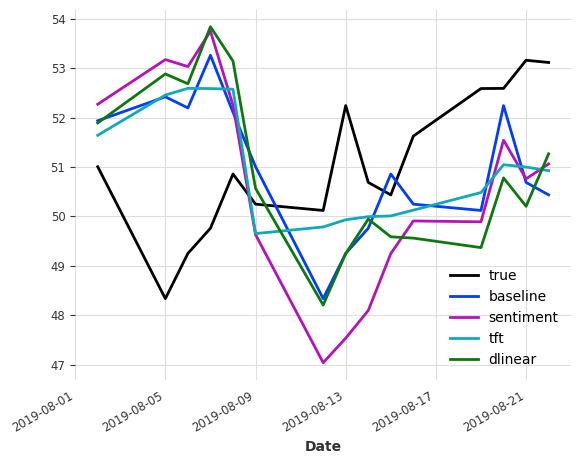

In [31]:
display_prediction_part(target_val, 180, 195, \
    {
        'baseline': hist_baseline,
        # 'default': hist_def,
        # 'minmax': hist_mm,
        # 'covariate': hist_mm_cov,
        'sentiment': hist_sentiment,
        # 'sentiment_opt': hist_sentiment_opt,
        'tft': hist_tft_sentiment_opt,
        'dlinear': hist_dlinear_sentiment
    })

baseline errors
MAPE error is 2.42541 % 
MAE error is 1.41388 % 
R2 error is 0.27272 % 
RMSE error is 1.64058 % 
SMAPE error is 2.46506 %
----------------------------------------------------------
sentiment errors
MAPE error is 2.32678 % 
MAE error is 1.33905 % 
R2 error is 0.28414 % 
RMSE error is 1.62766 % 
SMAPE error is 2.34836 %
----------------------------------------------------------
tft errors
MAPE error is 2.33235 % 
MAE error is 1.36046 % 
R2 error is 0.35742 % 
RMSE error is 1.54209 % 
SMAPE error is 2.36752 %
----------------------------------------------------------
dlinear errors
MAPE error is 1.77230 % 
MAE error is 1.01812 % 
R2 error is 0.56618 % 
RMSE error is 1.26708 % 
SMAPE error is 1.78667 %
----------------------------------------------------------


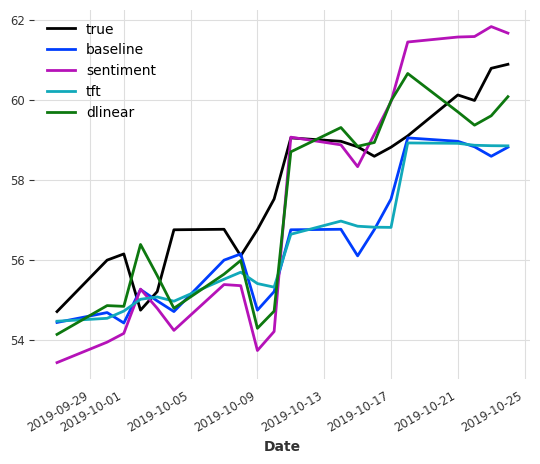

In [32]:
display_prediction_part(target_val, 220, 240, \
    {
        'baseline': hist_baseline,
        # 'default': hist_def,
        # 'minmax': hist_mm,
        # 'covariate': hist_mm_cov,
        'sentiment': hist_sentiment,
        # 'sentiment_opt': hist_sentiment_opt,
        'tft': hist_tft_sentiment_opt,
        'dlinear': hist_dlinear_sentiment
    })

baseline errors
MAPE error is 2.06728 % 
MAE error is 1.41780 % 
R2 error is 0.39977 % 
RMSE error is 1.61692 % 
SMAPE error is 2.08986 %
----------------------------------------------------------
sentiment errors
MAPE error is 1.99639 % 
MAE error is 1.35610 % 
R2 error is 0.42241 % 
RMSE error is 1.58613 % 
SMAPE error is 1.99808 %
----------------------------------------------------------
tft errors
MAPE error is 1.97197 % 
MAE error is 1.35420 % 
R2 error is 0.42932 % 
RMSE error is 1.57661 % 
SMAPE error is 1.99265 %
----------------------------------------------------------
dlinear errors
MAPE error is 2.15123 % 
MAE error is 1.44957 % 
R2 error is 0.27525 % 
RMSE error is 1.77673 % 
SMAPE error is 2.14948 %
----------------------------------------------------------


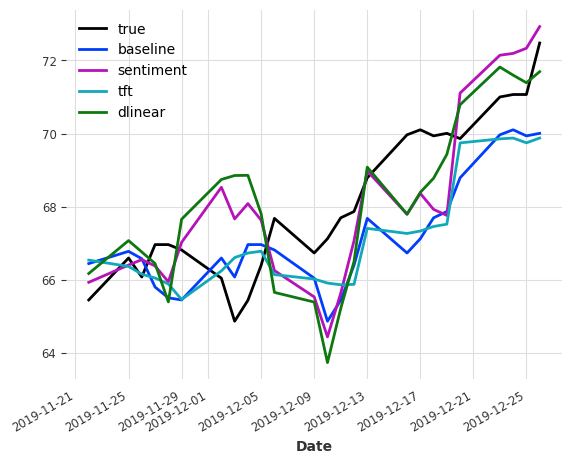

In [33]:
display_prediction_part(target_val, 260, 285, \
    {
        'baseline': hist_baseline,
        # 'default': hist_def,
        # 'minmax': hist_mm,
        # 'covariate': hist_mm_cov,
        'sentiment': hist_sentiment,
        # 'sentiment_opt': hist_sentiment_opt,
        'tft': hist_tft_sentiment_opt,
        'dlinear': hist_dlinear_sentiment
    })

There is little difference between using MinMax scaling and the normalization that is introduced in the paper for stock prices.

We will stick with minmax due to better accuracy.